# Testing Dask with Mongo

Install docker, pymongo and dask first as dependencies

In [1]:
%pip install docker pymongo dask

You should consider upgrading via the '/home/rachelle2/.pyenv/versions/3.6.9/envs/laputa-3.6/bin/python3.6 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Set Up Mongo Docker Image
NOTE : this reuses the other notebook's same configuration for simplicity's sake

In [1]:
import os
import docker

docker_client = docker.from_env()

mongo_container = docker_client.containers.run(
    'mongo:latest',
    detach=True,
    name='mongo-data-prep',
    remove=True,
    ports={'27017/tcp': 27018},
    mem_limit='512M',
    volumes={
        os.path.join(os.getcwd(), 'db'): {'bind': '/data/db', 'mode': 'rw'},
        os.path.join(os.getcwd(), 'mongo.conf'): {'bind': '/etc/mongo.conf', 'mode': 'ro'}
    }
)

Add logging

In [2]:
mongo_container.logs()

b'2020-05-12T12:04:30.637+0000 I  CONTROL  [main] Automatically disabling TLS 1.0, to force-enable TLS 1.0 specify --sslDisabledProtocols \'none\'\n2020-05-12T12:04:30.643+0000 W  ASIO     [main] No TransportLayer configured during NetworkInterface startup\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] MongoDB starting : pid=1 port=27017 dbpath=/data/db 64-bit host=3c9bc5927328\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] db version v4.2.5\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] git version: 2261279b51ea13df08ae708ff278f0679c59dc32\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] OpenSSL version: OpenSSL 1.1.1  11 Sep 2018\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] allocator: tcmalloc\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] modules: none\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten] build environment:\n2020-05-12T12:04:30.643+0000 I  CONTROL  [initandlisten]     distmod: ubuntu1804\n2020-05-

# Set Up Mongo Client

Get the Mongo client and add a database named `prep-test` to it.

In [11]:
from pymongo import InsertOne, MongoClient
mongo_client = MongoClient('127.0.0.1', 27018)
db = mongo_client['prep-test']

In [12]:
mongo_client.server_info()

{'version': '4.2.5',
 'gitVersion': '2261279b51ea13df08ae708ff278f0679c59dc32',
 'modules': [],
 'allocator': 'tcmalloc',
 'javascriptEngine': 'mozjs',
 'sysInfo': 'deprecated',
 'versionArray': [4, 2, 5, 0],
 'openssl': {'running': 'OpenSSL 1.1.1  11 Sep 2018',
  'compiled': 'OpenSSL 1.1.1  11 Sep 2018'},
 'buildEnvironment': {'distmod': 'ubuntu1804',
  'distarch': 'x86_64',
  'cc': '/opt/mongodbtoolchain/v3/bin/gcc: gcc (GCC) 8.2.0',
  'ccflags': '-fno-omit-frame-pointer -fno-strict-aliasing -ggdb -pthread -Wall -Wsign-compare -Wno-unknown-pragmas -Winvalid-pch -Werror -O2 -Wno-unused-local-typedefs -Wno-unused-function -Wno-deprecated-declarations -Wno-unused-const-variable -Wno-unused-but-set-variable -Wno-missing-braces -fstack-protector-strong -fno-builtin-memcmp',
  'cxx': '/opt/mongodbtoolchain/v3/bin/g++: g++ (GCC) 8.2.0',
  'cxxflags': '-Woverloaded-virtual -Wno-maybe-uninitialized -fsized-deallocation -std=c++17',
  'linkflags': '-pthread -Wl,-z,now -rdynamic -Wl,--fatal-war

# Generate Random Data

We also check here if anything has been inserted into the Mongo database

NOTE: The name of the collection is `test_data`

In [18]:
import random

COLLECTION_NAME = 'test_data'
MAX_NUM_OF_DOCS = 1001

# Template of doc looks like { 'color' : 'purple', 'number' : 1, 'random' : 'PUPPIES' }
# Lists and number ranged to populate the random documents
list_of_random = ['PUPPIES', 'CHOCOLATE', 'SONATA', 'RATATOUILLE', 'HYPERDRIVE', 'RIFIFI']
list_of_colors = ['black', 'orange', 'purple', 'red', 'blue']
NUM_CAP = 101

def generate_doc():
    return {
        'color' : random.choice(list_of_colors),
        'number' : random.choice(range(NUM_CAP)),
        'random' : random.choice(list_of_random)
    }

def insert_doc():
    return InsertOne(generate_doc())
      
def check_for_data():
    return db[COLLECTION_NAME].find_one()

def load_data_into_db(max_num_of_docs):
    db[COLLECTION_NAME].drop()
    db[COLLECTION_NAME].bulk_write([insert_doc() for i in range(max_num_of_docs)])

load_data_into_db(MAX_NUM_OF_DOCS)
check_for_data()

{'_id': ObjectId('5eba9b207f4ccc9d8fbfa85e'),
 'color': 'purple',
 'number': 74,
 'random': 'CHOCOLATE'}

# Mongo Pipeline
These functions are to emulate a Mongo pipeline

In [30]:
def find_all_purple_lte_50(col):
    col_name = 'purple'
    pipeline = [
        { '$match': { 'color': 'purple', 'number': { '$lte': 50 } } },
        { '$out' : col_name }
    ]
    db[col].aggregate(pipeline)
    return col_name

def find_all_orange_gt_50(col):
    col_name = 'orange'
    pipeline = [
        { '$match' : { 'color' : 'orange', 'number' : { '$gt' : 50} } },
        { '$out' : col_name }
    ]
    db[col].aggregate(pipeline)
    return col_name
    
def group_orange_purple(col1, col2):
    pipeline = [
        {
            '$match' : { 'color' : col1 }
        },
        {
            "$group": {
              "_id": None,
              "_vqbPipelineInline": {
                "$push": "$$ROOT"
              }
            }
        },
        {
            "$lookup": {
              "from": col2,
              "pipeline": [
                {
                  "$match": {}
                },
                {
                  "$project": {
                    "_id": 0
                  }
                }
              ],
              "as": "_vqbPipelineToAppend_0"
            }
        },
        {
            "$project": {
              "_vqbPipelinesUnion": {
                "$concatArrays": [
                  "$_vqbPipelineInline",
                  "$_vqbPipelineToAppend_0"
                ]
              }
            }
        },
        {
            "$unwind": "$_vqbPipelinesUnion"
        },
        {
            "$replaceRoot": {
              "newRoot": "$_vqbPipelinesUnion"
        }
        },
        {
            '$out' : 'result'
        }
    ]
    return db.purple.aggregate(pipeline)

col_1 = find_all_purple_lte_50(COLLECTION_NAME)
col_2 = find_all_orange_gt_50(COLLECTION_NAME)
group_orange_purple(col_1, col_2)

list(db.result.find({}))

[{'_id': ObjectId('5eba9b207f4ccc9d8fbfa869'),
  'color': 'purple',
  'number': 17,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa86c'),
  'color': 'purple',
  'number': 19,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa86f'),
  'color': 'purple',
  'number': 13,
  'random': 'PUPPIES'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa871'),
  'color': 'purple',
  'number': 17,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa885'),
  'color': 'purple',
  'number': 30,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa88c'),
  'color': 'purple',
  'number': 41,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa891'),
  'color': 'purple',
  'number': 38,
  'random': 'RIFIFI'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa895'),
  'color': 'purple',
  'number': 48,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa897'),
  'color': 'purple',
  'number': 33,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId(

Drop the tested collections to wipe them clean

In [31]:
db.purple.drop()
db.orange.drop()
db.result.drop()

# Set up Dask as task runner

In [34]:
dsk = {
    'input1' : COLLECTION_NAME,
    'output1' : (find_all_purple_lte_50, 'input1'),
    'output2' : (find_all_orange_gt_50, 'input1'),
    'output3' : (group_orange_purple, 'output1', 'output2')
}

import dask and use it to do stuff

In [37]:
import dask

dask.get(dsk, ['output3'])
list(db.result.find({}))

[{'_id': ObjectId('5eba9b207f4ccc9d8fbfa869'),
  'color': 'purple',
  'number': 17,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa86c'),
  'color': 'purple',
  'number': 19,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa86f'),
  'color': 'purple',
  'number': 13,
  'random': 'PUPPIES'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa871'),
  'color': 'purple',
  'number': 17,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa885'),
  'color': 'purple',
  'number': 30,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa88c'),
  'color': 'purple',
  'number': 41,
  'random': 'SONATA'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa891'),
  'color': 'purple',
  'number': 38,
  'random': 'RIFIFI'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa895'),
  'color': 'purple',
  'number': 48,
  'random': 'CHOCOLATE'},
 {'_id': ObjectId('5eba9b207f4ccc9d8fbfa897'),
  'color': 'purple',
  'number': 33,
  'random': 'RATATOUILLE'},
 {'_id': ObjectId(

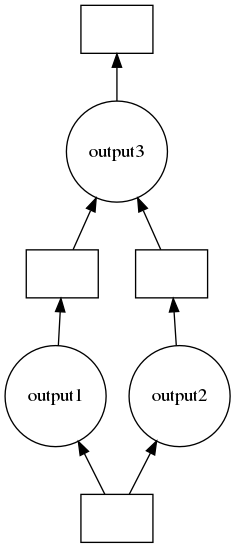

In [36]:
dask.visualize(dsk)